# Capstone Two: Modeling

In this step of my capstone, I am going to be assessing different models (and tuning hyperparamteters) in order to find the best model I can. 

1. Import training and testing files and libraries. 
2. Use the last month's sales as a benchmark. 
3. Machine learning
4. Hyperparameter tuning

### 1. Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.model_selection import KFold

import os
from library.sb_utils import save_file

In [2]:
training = pd.read_csv('./data/training_data_feature_engineered.csv')
testing = pd.read_csv('./data/testing_data_feature_engineered.csv')
# sample_submission = pd.read_csv("./data/sample_submission.csv")

In [3]:
testing.head()

,ID,shop_id,item_id,date_block_num,item_category_id,November,2015,num_holidays,April,August,...,January,July,June,March,May,October,September,2013,2014,item_month_avg_price
0,0,5,5037,34,19,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1926.828388
1,1,5,5320,34,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1026.495015
2,2,5,5233,34,19,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,800.777500
3,3,5,5232,34,23,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,790.512923
4,4,5,5268,34,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1026.495015


In [4]:
training.head()

,date_block_num,shop_id,item_id,item_price,item_category_id,April,August,December,February,January,...,May,November,October,September,2013,2014,2015,item_cnt_month,item_month_avg_price,num_holidays
0,0,59,22154,999.00,37,0,0,0,0,1,...,0,0,0,0,1,0,0,1.0,999.00,1
1,0,25,2552,899.00,58,0,0,0,0,1,...,0,0,0,0,1,0,0,0.0,899.00,2
2,0,25,2552,899.00,58,0,0,0,0,1,...,0,0,0,0,1,0,0,0.0,899.00,2
3,0,25,2554,1709.05,58,0,0,0,0,1,...,0,0,0,0,1,0,0,1.0,1709.05,1
4,0,25,2555,1099.00,56,0,0,0,0,1,...,0,0,0,0,1,0,0,1.0,1099.00,0


### 2. Use last months sales as a benchmark. 

In [5]:
prev_month_selector = (training['October'] == 1) & (training['2015'] == 1)
last_month = training[prev_month_selector]
groups = last_month[["shop_id", "item_id",'item_cnt_month']].groupby(by=['shop_id','item_id'])
groups = groups.agg({'item_cnt_month':'sum'}).reset_index()

In [6]:
merged = testing.merge(groups, on=["shop_id", "item_id"], how="left")[["ID", "item_cnt_month"]] 
print(testing.shape)
print(groups.shape)
print(merged.shape)
merged.isna().sum()

(214200, 22)
(31531, 3)
(214200, 2)


ID                     0
item_cnt_month    185520
dtype: int64

In [7]:
merged.item_cnt_month = merged.item_cnt_month.fillna(0)
merged.head()
merged.shape

(214200, 2)

In [8]:
datapath = './data'
save_file(merged, 'baseline.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)n

Please re-run this cell with a new filename.


Sumbitting this to the Kaggle competition gives me a RMSE of 4.56066, which is a bad score. However, this does give us a very rudimentary baseline. 

### 3. Machine Learning

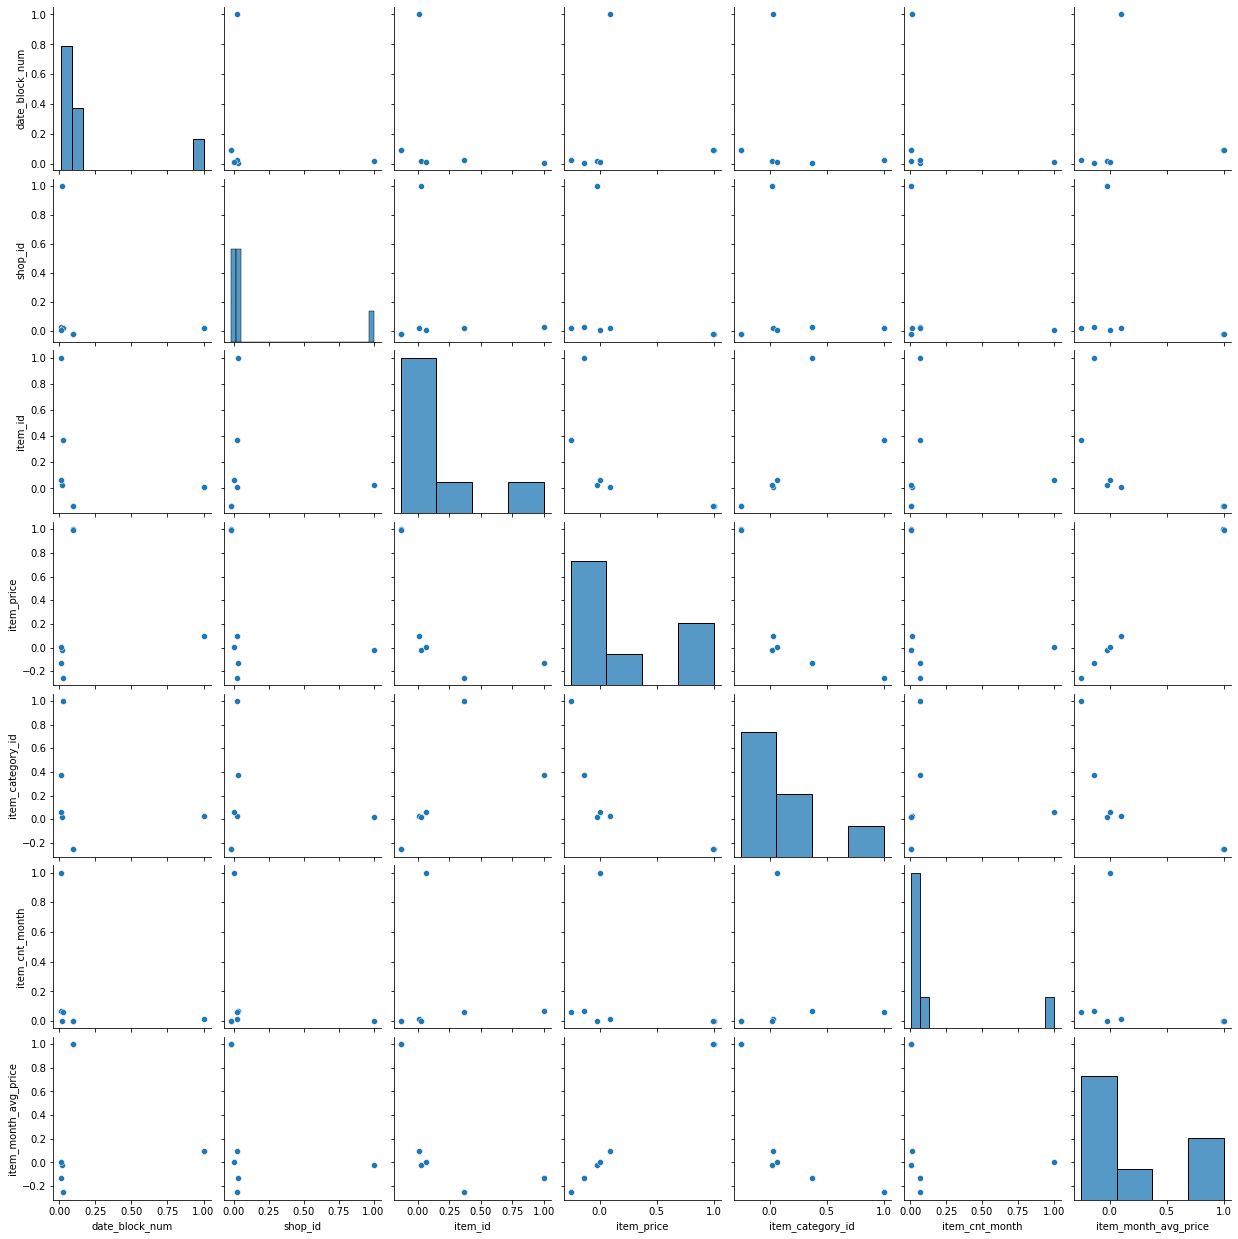

In [9]:
no_times=training.drop(['November', '2015', 'num_holidays', 'April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'October','September', '2013', '2014'], axis=1)
sns.pairplot(no_times.corr())

<AxesSubplot:>

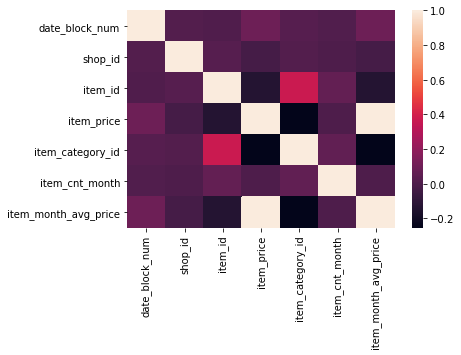

In [10]:
sns.heatmap(no_times.corr())

In [11]:
no_times.shape

(2935843, 7)

In [19]:
testing.shape

(214200, 22)

In [20]:
training.shape

(2935843, 23)

In [12]:
train_cols = training.columns.to_list()
test_cols = testing.columns.to_list()
print(list(set(train_cols).difference(test_cols)))
print(list(set(test_cols).difference(train_cols)))

['item_price', 'item_cnt_month']
['ID']


In [13]:
X = training.drop(['item_cnt_month','item_price'], axis=1)
y = training['item_cnt_month']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [15]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train) # eval_metric='rmse'

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [16]:
y_pred = model.predict(X_test)

In [17]:
# predictions = [round(value) for value in y_pred]
# evaluate predictions
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

r2 = r2_score(y_test, y_pred)
print("R-squared score:",(r2))

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:",(mse))

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root mean Squared Error:",(rmse))

R-squared score: 0.9213087154886476
Mean Squared Error: 71.68691803107419
Root mean Squared Error: 8.4668127433571


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

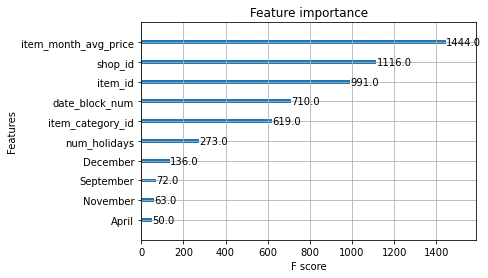

In [18]:
xgb.plot_importance(model, max_num_features = 10)

In [21]:
#Building the Stochastic Gradient Descent Model on our dataset
from sklearn.linear_model import SGDRegressor
SGD_model = SGDRegressor().fit(X_train,y_train)
SGD_predict = SGD_model.predict(X_test) #Predictions on Testing data
# predictions = [round(value) for value in y_pred]
# evaluate predictions
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

r2 = r2_score(y_test, SGD_predict)
print("R-squared score:",(r2))

mse = mean_squared_error(y_test, SGD_predict)
print("Mean Squared Error:",(mse))

rmse = mean_squared_error(y_test, SGD_predict, squared=False)
print("Root mean Squared Error:",(rmse))

R-squared score: -6.449831014100723e+26
Mean Squared Error: 5.8757270273738465e+29
Root mean Squared Error: 766532910407234.0
